<a href="https://colab.research.google.com/github/LeonardoFM73/ProjectUASIMDB/blob/main/Netflix_Master_Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#untuk mount google drive dimana terdapat 3 file dataset yang nantinya akan digunakan
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Cleaning Data
import pandas as pd 
import numpy as np
import pycountry_convert as pc

from textblob import TextBlob
from google.colab import files
import time
import pycountry_convert as pc
titles = pd.read_csv('/content/gdrive/MyDrive/DataIMDB/netflix_titles.csv')
title_ratings = pd.read_csv("/content/gdrive/MyDrive/DataIMDB/title.basics.tsv", sep='\t')
ratings = pd.read_csv("/content/gdrive/MyDrive/DataIMDB/title.ratings.tsv", sep='\t')

def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return "Unknown"


if __name__ == '__main__':    
    print(f'Launching the data cleaning')
    starttime = time.time()

    title_ratings['title_lowered'] = title_ratings['primaryTitle'].apply(lambda x: str(x).lower())
    titles['title_lowered'] = titles['title'].apply(lambda x: str(x).lower())

    reference = pd.merge(title_ratings, ratings, on='tconst')
    reference = reference[['title_lowered', 'averageRating', 'isAdult']] \
    .set_index("title_lowered") \
    .to_dict()

    titles['rating'] = titles['title_lowered'].apply(lambda x: reference['averageRating'][x] if x in reference['averageRating'] else None)
    titles = titles[titles['rating'].notna()]

    titles['is_adult'] = titles['title_lowered'].apply(lambda x: int(reference['isAdult'][x]) if x in reference['isAdult'] else None)

    titles['polarity'] = titles['description'].apply(lambda x: TextBlob(x).sentiment.polarity)
    titles['subjectivity'] = titles['description'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    titles['duration'] = titles['duration'].str.replace(' Seasons', '')
    titles['duration'] = titles['duration'].str.replace(' Season', '')
    titles['duration'] = titles['duration'].str.replace(' min', '')

    titles['duration'] = titles['duration'].astype("int64")
    titles['release_year'] = titles['release_year'].astype("int64")

    max_dur_movie = titles.loc[titles['type'] == "Movie", "duration"].max()
    min_dur_movie = titles.loc[titles['type'] == "Movie", "duration"].min()

    max_dur_tv = titles.loc[titles['type'] == "TV Show", "duration"].max()
    min_dur_tv = titles.loc[titles['type'] == "TV Show", "duration"].min()

    max_release = titles["release_year"].max()
    min_release = titles["release_year"].min()

    titles['continent'] = titles['country'].apply(lambda x: country_to_continent(x.split(",")[0]) if x == x else "Unknown")
    titles.drop(["show_id", "director", "cast", "date_added", "description", "title_lowered", "country", "listed_in"], axis=1, inplace=True)

    #titles
    titles.to_csv('clean_data_Final.csv')
    files.download('clean_data_Final.csv')

    print('Time taken = {} seconds'.format(time.time() - starttime))

KeyboardInterrupt: ignored

In [ ]:
titles

,type,title,release_year,rating,duration,is_adult,polarity,subjectivity,continent
0,Movie,Norm of the North: King Sized Adventure,2019,3.3,90,0,0.033333,0.516667,North America
1,Movie,Jandino: Whatever it Takes,2016,4.5,94,0,0.000000,0.000000,Europe
2,TV Show,Transformers Prime,2013,7.9,1,0,0.000000,0.100000,North America
3,TV Show,Transformers: Robots in Disguise,2016,6.0,1,0,0.136364,0.454545,North America
4,Movie,#realityhigh,2017,5.1,99,0,0.048333,0.401667,North America
...,...,...,...,...,...,...,...,...,...
6228,TV Show,Kikoriki,2010,7.7,2,0,0.414286,0.692857,Unknown
6229,TV Show,Red vs. Blue,2015,7.3,13,0,-0.050000,0.050000,North America
6230,TV Show,Maron,2016,7.7,4,0,0.425000,0.850000,North America
6231,Movie,Little Baby Bum: Nursery Rhyme Friends,2016,7.1,60,0,0.525000,0.683333,Unknown


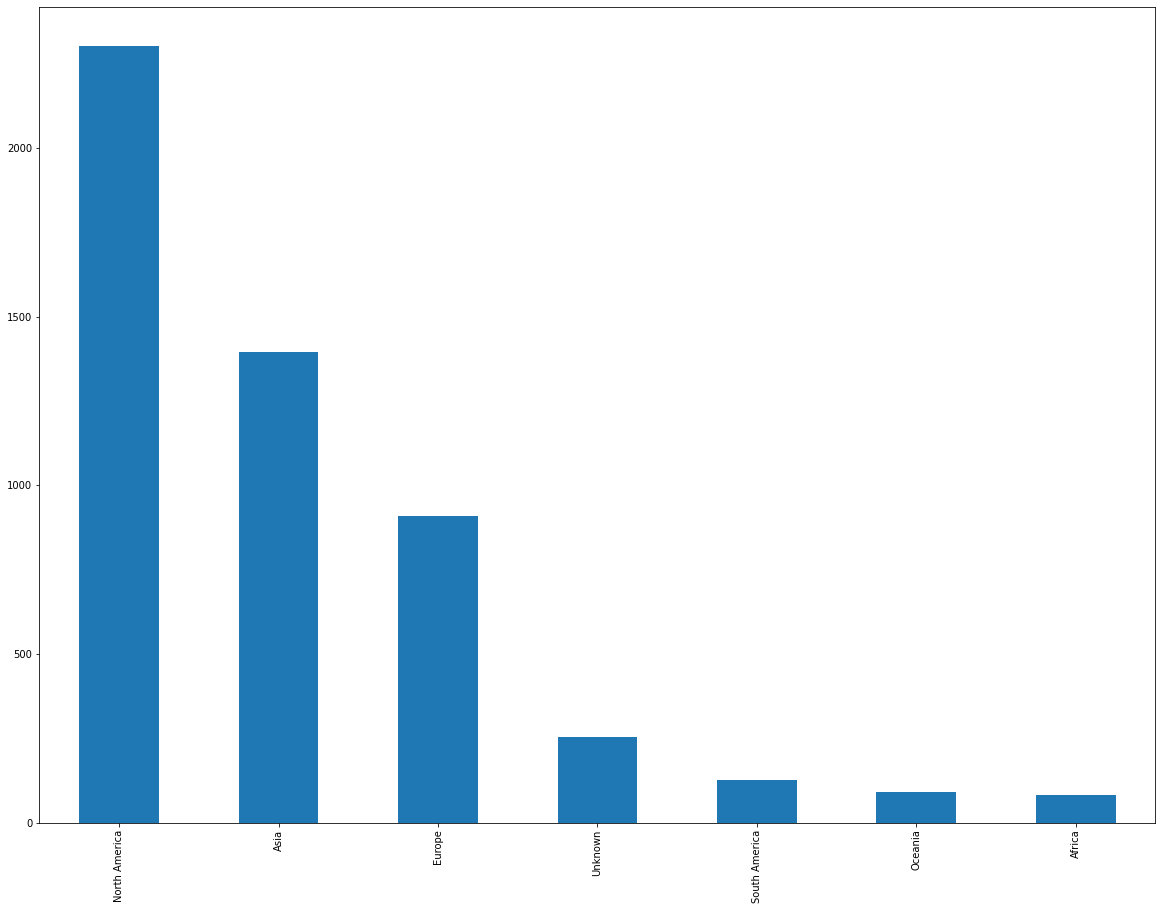

In [ ]:
#Showing plot
titles['continent'].value_counts(sort=True).plot(kind="bar", figsize=(20, 15))

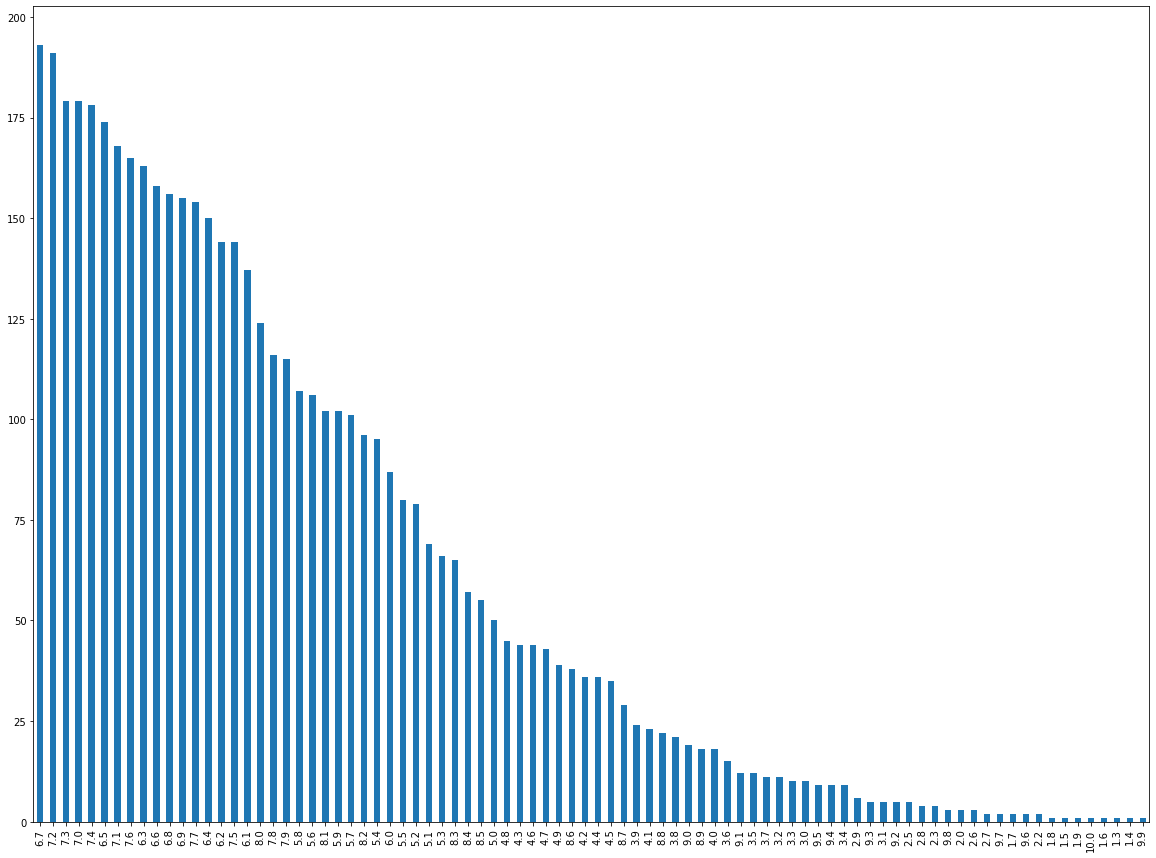

In [ ]:
titles['rating'].value_counts(sort=True).plot(kind="bar",figsize=(20, 15))

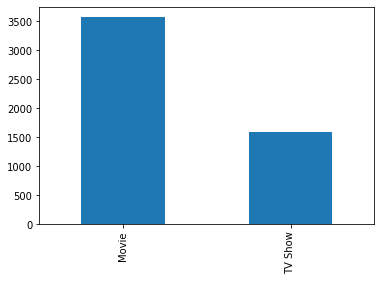

In [ ]:
titles['type'].value_counts(sort=True).plot(kind="bar")

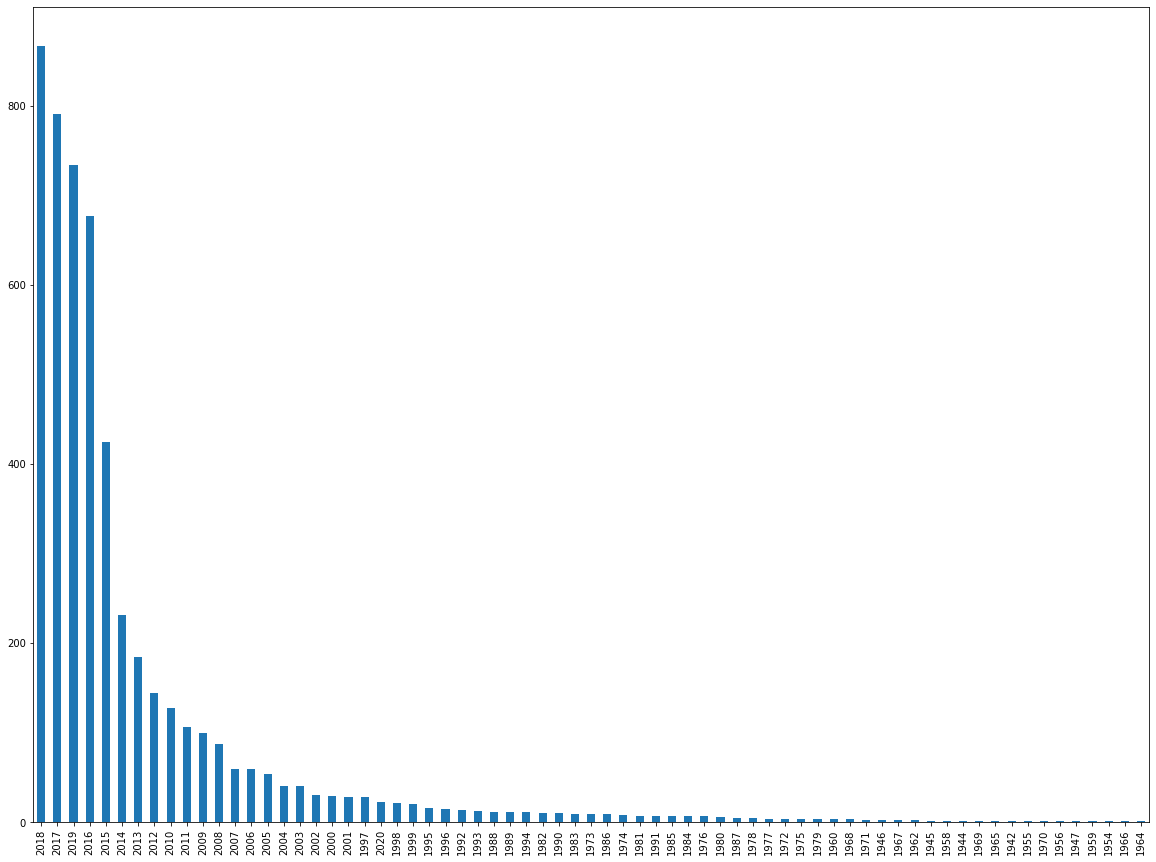

In [ ]:
titles['release_year'].value_counts(sort=True).plot(kind="bar",figsize=(20, 15))

In [3]:
#Program Fuzzy
import numpy as np
import pandas as pd
import time
import skfuzzy as fuzz
from datetime import datetime
from skfuzzy import control as ctrl
import urllib.request as urllib2

netflix = 'https://raw.githubusercontent.com/LeonardoFM73/ProjectUASIMDB/main/clean_data_Final.csv'


def set_up_rule(Tipe):
    # crisp set
    release_year = ctrl.Antecedent(np.arange(1942, 2020, 1), 'Year')
    title_len = ctrl.Antecedent(np.arange(5, 27, 1), 'Title Length')
    if(Tipe =='Movie'):
      duration = ctrl.Antecedent(np.arange(3, 312, 1), 'Movie Length')
    elif (Tipe=='TV Show'):
      duration = ctrl.Antecedent(np.arange(1, 15, 1), 'Movie Length')
    polarity = ctrl.Antecedent(np.arange(-1, 1, 0.00001), 'Polarity')
    subjectivity = ctrl.Antecedent(np.arange(0, 1, 0.00001), 'Subjectivity')
    reviews = ctrl.Antecedent(np.arange(0, 10, 0.1), 'Reviews')
    # Internal State of the user
    mood = ctrl.Antecedent(np.arange(0, 11, 0.1), 'Mood')
    physical_state = ctrl.Antecedent(np.arange(0, 11, 0.1), 'Physcial State')
    time = ctrl.Antecedent(np.arange(0, 25, 1), 'Time of The Day')

    #Fuzzification
    # Automatically generated Triangular membership functions for a set of antecedents.
    release_year.automf(5, names=['Very Old', 'Old', 'Not So Old', 
                                    'New', 'Very New'])
    title_len.automf(5, names=['Very Short', 'Short', 'Not So Short',
                                'Long', 'Very Long'])
    polarity.automf(5, names=['Very Negative', 'Negative', 'Not So Negative', 
                                'Positive', 'Very Positive'])
    subjectivity.automf(5, names=['Very Subjective', 'Subjective', 'Not So Subjective', 
                                'Objective/Factual', 'Very Objective/Factual'])
    time.automf(5, names=['Very Early', 'Early', 'Not So Early', 
                            'Late', 'Very Late'])
    reviews.automf(3, names=['Poor', 'Average', 'Good'])

    mood.automf(5, names=['Very Upset', 'Upset', 'Neutral', 
                            'Happy', 'Very Happy'])
    physical_state.automf(5, names=['Exhausted', 'Tired', 
                                        'Not So Tired', 'Lively', 'Very Lively'])
    duration.automf(5,names=['Very Short','Short','Not So Short','Long','Very Long'])

    ### Defining the Consequent
    recommend = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'Recommendation Score')
    
    # Define the membership function of the consequent. For this I chose a sigmoid membership function. 
    recommend['Recommend'] = fuzz.smf(recommend.universe, 0, 1)
    
    #rule_set
    rule_1 = ctrl.Rule(mood['Very Happy'] & physical_state['Very Lively'] & (reviews['Average'] | release_year['New'] |
                                release_year['Very New']), recommend['Recommend'])

    rule_2 = ctrl.Rule(mood['Very Happy'] & physical_state['Lively'] & (reviews['Average'] | release_year['New']), 
                                recommend['Recommend'])

    rule_3 = ctrl.Rule(mood['Very Happy'] & physical_state['Not So Tired'] & (reviews['Good'] | release_year['New']) &
                                    duration['Not So Short'], recommend['Recommend'])

    rule_4 = ctrl.Rule(mood['Very Happy'] & physical_state['Tired'] & (reviews['Good'] | release_year['New']) & duration['Short'] &
                                subjectivity['Subjective'] & polarity['Not So Negative'], recommend['Recommend'])
                                                                                                                    
    rule_5 = ctrl.Rule(mood['Very Happy'] & physical_state['Exhausted'] & (reviews['Good'] | release_year['New']) & duration['Very Short'] & 
                            (subjectivity['Subjective'] | subjectivity['Very Subjective']) & polarity['Not So Negative'], recommend['Recommend'])

    rule_6 = ctrl.Rule(mood['Happy'] & physical_state['Very Lively'] & (reviews['Good'] | release_year['Not So Old']),
                            recommend['Recommend'])

    rule_7 = ctrl.Rule(mood['Happy'] & (physical_state['Very Lively'] | physical_state['Lively']) & (reviews['Average'] |
                                release_year['Not So Old']), recommend['Recommend'])

    rule_8 = ctrl.Rule(mood['Happy'] & physical_state['Not So Tired'] & (reviews['Average'] | release_year['Not So Old'] |
                        release_year['New']), recommend['Recommend'])

    rule_9 = ctrl.Rule(mood['Happy'] & physical_state['Tired'] & reviews['Good'] & (release_year['Not So Old'] |
                        release_year['New']) & polarity['Not So Negative'] & duration['Short'], recommend['Recommend'])

    rule_10 = ctrl.Rule(mood['Happy'] & physical_state['Exhausted'] & reviews['Good'] & release_year['Not So Old']
                        & polarity['Very Positive'] & (duration['Short'] | duration['Very Short']), recommend['Recommend'])

    rule_11 = ctrl.Rule(mood['Neutral'] & (physical_state['Very Lively'] | physical_state['Lively'] | physical_state['Not So Tired']) &
                        (reviews['Average'] | reviews['Good']) & (release_year['Not So Old'] | release_year['New'] | release_year['Very New']) 
                        & (duration['Not So Short'] | duration['Short']) & (time['Early'] | time['Not So Early']), recommend['Recommend'])

    rule_12 = ctrl.Rule(mood['Neutral'] & physical_state['Tired'] & reviews['Good']
                        & (release_year['Not So Old'] | release_year['New']) & duration['Short'] & (time['Early'] | time['Not So Early'])
                        , recommend['Recommend'])

    rule_13 = ctrl.Rule(mood['Neutral'] & physical_state['Exhausted'] & reviews['Good']
                        & (release_year['Not So Old'] | release_year['New']) & duration['Very Short'] & (time['Early'] | time['Not So Early'])
                        , recommend['Recommend'])

    rule_14 = ctrl.Rule(mood['Upset'] & (physical_state['Very Lively'] | physical_state['Lively'] | physical_state['Not So Tired']) &
                        (reviews['Good'] | reviews['Average'] ) & (release_year['New'] | release_year['Very New']) & 
                        (polarity['Positive'] | polarity['Very Positive']), recommend['Recommend'])

    rule_15 = ctrl.Rule((mood['Upset'] | mood['Very Upset']) & (physical_state['Tired'] | time['Late'] | time['Very Late']) &
                        (reviews['Good'] | reviews['Average'] ) & (release_year['New'] | release_year['Very New']) & 
                        (polarity['Positive'] | polarity['Very Positive']) & (duration['Short'] | duration['Very Short']),
                        recommend['Recommend'])

    rule_16 = ctrl.Rule((mood['Upset'] | mood['Very Upset']) & (physical_state['Exhausted'] | time['Late'] | time['Very Late']) &
                        (reviews['Good'] | reviews['Average'] ) & (release_year['New'] | release_year['Very New']) & 
                        (polarity['Positive'] | polarity['Very Positive']) & duration['Short'],
                        recommend['Recommend'])
    
    # Initialize the Fuzzy Rule Base.
    netflix_ctrl = ctrl.ControlSystem([rule_1, rule_2, rule_3, rule_4, rule_5, rule_6, rule_7, rule_8,
                                        rule_9, rule_10, rule_11, rule_12, rule_13, rule_14, rule_15, rule_16])
    
    return netflix_ctrl

class MovieController:
    def __init__(self,Tipe):
        self.data=pd.read_csv(netflix, index_col=[0],encoding='latin-1').reset_index(drop=True) 
        self.netflix_ctrl = set_up_rule(Tipe)
        
    def create_sim_instance(self, name):
        self.name = ctrl.ControlSystemSimulation(self.netflix_ctrl) # Create a simulation instance
    
    def filter(self,Tipe,age,Continent):
        if Tipe == 'Movie':
          self.data=self.data[(self.data.type == 'Movie')]
          self.movie_set = {'Title' : [], 'Duration (minutes)' : [],'Rating' : [], 'Scores' : []}
        elif Tipe =='TV Show':
          self.data=self.data[(self.data.type == 'TV Show')]
          self.movie_set = {'Title' : [], 'Season' : [], 'Rating' : [], 'Scores' : []}


        if age<18:
          self.data=self.data[(self.data.is_adult == 0)].dropna()
        else:
          self.data     

        if Continent == 'Asia':
          self.data=self.data[self.data.continent.apply(lambda x: x in ['Asia','Unknown'])].dropna()
        elif Continent == 'Africa':
          self.data=self.data[self.data.continent.apply(lambda x: x in ['Africa','Unknown'])].dropna()
        elif Continent == 'America':
          self.data=self.data[self.data.continent.apply(lambda x: x in ['North America','South America','Unknown'])].dropna()
        elif Continent == 'Europe':
          self.data=self.data[self.data.continent.apply(lambda x: x in ['Europe','Unknown'])].dropna()
        elif Continent == 'Oceania':
          self.data=self.data[self.data.continent.apply(lambda x: x in ['Oceania','Unknown'])].dropna()
        elif Continent == 'All':
          self.data=self.data

    def calculate(self, mood, physical_state, Tipe):
        for index in range(len(self.data)):
            try:
                self.name.input['Mood'] = mood
                self.name.input['Physcial State'] = physical_state
                self.name.input['Year'] = self.data.release_year.iloc[index]
                self.name.input['Movie Length'] = int(self.data.duration.iloc[index])
                self.name.input['Polarity'] = int(self.data.polarity.iloc[index])
                self.name.input['Subjectivity'] = int(self.data.subjectivity.iloc[index])
                self.name.input['Reviews'] = int(self.data.rating.iloc[index])
                self.name.input['Time of The Day'] = datetime.now().hour
                
                self.name.compute()
                if Tipe =='Movie':
                  self.movie_set['Title'].append(self.data.title.iloc[index])
                  self.movie_set['Duration (minutes)'].append(self.data.duration.iloc[index])
                  self.movie_set['Rating'].append(self.data.rating.iloc[index])
                  self.movie_set['Scores'].append(self.name.output['Recommendation Score'])
                elif Tipe == 'TV Show':
                  self.movie_set['Title'].append(self.data.title.iloc[index])
                  self.movie_set['Season'].append(self.data.duration.iloc[index])
                  self.movie_set['Rating'].append(self.data.rating.iloc[index])
                  self.movie_set['Scores'].append(self.name.output['Recommendation Score'])
                


            except: # This is necessary for cases where a given movie does not activate any of the rules in the rule base.
                pass


    def results(self):
        res = pd.DataFrame.from_dict(self.movie_set)
        first = res.sort_values(by=['Scores', 'Rating'], ascending=[False, False])[0:10] # Sorts by the Recommendation score and then by the Rotten Score. And selects the first 10.
        return first

if __name__ == '__main__':
    starttime = time.time()

    print('Selamat Datang pada prototype rekomendasi film netflix rating IMDB dengan pemodelan Fuzzy')
    print('')
    name = input('Siapakah namamu? ')
    age = input('Berapa umurmu sekarang? ')
    Tipe = input('Pilih Movie atau TV Show? ')

    continent = input('Mau filter untuk film dari benua tertentu saja (Ya/Tidak)? ')
    if continent == "Ya":
      Continent = input('Mau dari mana (Asia, Africa, America, Europe, Oceania)? ')
    else:
      Continent = "All"
    print('Terima kasih!')
    print('')
    print(f'Selamat Datang {name}.')
    print(f'Film dengan tipe {Tipe} berasal dari {Continent} akan dijadikan sebagai acuan.')
    print('')

    mood = input('Bagaimana keadaan moodmu sekarang 1 (Sangat Buruk) to  10 (Sangat Senang)? ')
    print('Terima kasih!')
    print('')

    physical_state = input('Bagaimana keadaan fisikmu sekarang 1 (Lelah) to 10 (Bersemangat)? ')
    print('')
    print('Terima kasih! Sekarang saya akan memproses beberapa rekomendasi bagimu.')
    print('')

    mv = MovieController(Tipe)
    mv.create_sim_instance(name)
    mv.filter(Tipe,int(age),Continent)
    mv.calculate(int(mood), int(physical_state),Tipe)
    print(mv.results())
    print('')

    print('Time taken = {} seconds'.format(time.time() - starttime))

Selamat Datang pada prototype rekomendasi film netflix rating IMDB dengan pemodelan Fuzzy

Siapakah namamu? Bagus Adi Wijaya
Berapa umurmu sekarang? 19
Pilih Movie atau TV Show? Movie
Mau filter untuk film dari benua tertentu saja (Ya/Tidak)? Ya
Mau dari mana (Asia, Africa, America, Europe, Oceania)? Asia
Terima kasih!

Selamat Datang Bagus Adi Wijaya.
Film dengan tipe Movie berasal dari Asia akan dijadikan sebagai acuan.

Bagaimana keadaan moodmu sekarang 1 (Sangat Buruk) to  10 (Sangat Senang)? 5
Terima kasih!

Bagaimana keadaan fisikmu sekarang 1 (Lelah) to 10 (Bersemangat)? 7

Terima kasih! Sekarang saya akan memproses beberapa rekomendasi bagimu.

                                          Title  Duration (minutes)  Rating  \
1018                                       Hero                  89     9.9   
8                                       One Day                 135     9.5   
136                                Clair Obscur                 102     9.4   
763                    

In [2]:
!pip install -r https://raw.githubusercontent.com/LeonardoFM73/ProjectUASIMDB/main/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 993 kB 19.1 MB/s 
     |████████████████████████████████| 10.1 MB 17.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 208 kB 40.1 MB/s 
     |████████████████████████████████| 297 kB 51.7 MB/s 
     |████████████████████████████████| 297 kB 47.4 MB/s 
     |████████████████████████████████| 297 kB 57.4 MB/s 
     |████████████████████████████████| 296 kB 50.3 MB/s 
     |████████████████████████████████| 296 kB 58.8 MB/s 
     |████████████████████████████████| 280 kB 61.9 MB/s 
     |████████████████████████████████| 280 kB 58.7 MB/s 
     |████████████████████████████████| 280 kB 37.3 MB/s 
     |████████████████████████████████| 280 kB 56.0 MB/s 
     |████████████████████████████████| 279 kB 57.2 MB/s 
     |██████████████